In [1]:
import torch
import numpy as np
import pandas as pd
from segregation.local import MultiLocalDiversity, MultiLocalEntropy

# visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.utils.get_nn_models import posterior_nn
from sbi.inference import (SNPE, SNLE, SNRE, 
                           prepare_for_sbi, 
                           simulate_for_sbi,
                           SMCABC)

# schelling
from model import Schelling

In [2]:
def simulator(par_values):
    pars={
    'width':80, 
    'height':80, 
    'density':0.9,
    'max_steps':100, 
    'mode':'Heterogeneous',
    'minority_pc':0.5, 
    'window_size':30, 
    'conv_threshold':0.01,
    'radius':1, 
    'torus':True,
    'move_fraction':0.15,
    'filename':'test.npz',
    'std1':0,
    'std2':0
    }

    pars['mu1'], pars['mu2'] = par_values
#     pars['mu1'], pars['std1'], pars['mu2'], pars['std2'] = par_values
    model = Schelling(pars)
    model.simulate()
    compositions = model.calc_neighbourhood_compositions(n=8)
    groups = ['group' + str(i) for i in range(2)]
    frame = pd.DataFrame(compositions, columns=groups)
    contributions = MultiLocalEntropy(data=frame, groups=groups).statistics
    return torch.as_tensor(sorted(contributions))
#     return torch.as_tensor([model.avg_fraction_sim])

In [3]:
true_mu1, true_std1, true_mu2, true_std2 = .3, 0, .4, 0
observation = simulator([true_mu1, true_mu2])
observation

tensor([-0.0000, 0.2387, 0.2730, 0.4754, 0.5086, 0.6052, 0.6573, 0.6940, 0.6987,
        0.7409, 0.7409, 0.7568, 0.7642, 0.7677, 0.7677, 0.7950, 0.8179, 0.8537,
        0.8663, 0.8663, 0.8813, 0.8936, 0.9059, 0.9236, 0.9241, 0.9306, 0.9348,
        0.9444, 0.9495, 0.9514, 0.9576, 0.9576, 0.9576, 0.9629, 0.9710, 0.9710,
        0.9748, 0.9751, 0.9764, 0.9812, 0.9815, 0.9819, 0.9819, 0.9829, 0.9831,
        0.9841, 0.9842, 0.9852, 0.9874, 0.9923, 0.9923, 0.9944, 0.9966, 0.9968,
        0.9981, 0.9983, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9998, 0.9998,
        0.9998], dtype=torch.float64)

In [4]:
prior = utils.BoxUniform(low=[0]*2, high=[1]*2)
posteriors = []
proposal = prior
num_simulations = [1000, 1000, 1000]

sbi_simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior=prior)

for number in num_simulations:
    theta, x = simulate_for_sbi(sbi_simulator, proposal, 
                                num_simulations=number, 
                                num_workers=8,
                                simulation_batch_size=1)
    density_estimator = inference.append_simulations(theta, x, 
                                                     proposal=proposal
                                                    ).train()
    method = 'rejection'
    posterior = inference.build_posterior(density_estimator,
#                                          sample_with=method,
#                                          vi_parameters=None,
#                                          mcmc_parameters={'num_workers':6, 'thin':5}
                                         )
    
    if method=='vi':
        posterior.set_default_x(observation)
        posterior.train()

    posteriors.append(posterior)
    proposal = posterior.set_default_x(observation)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 109 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 74 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

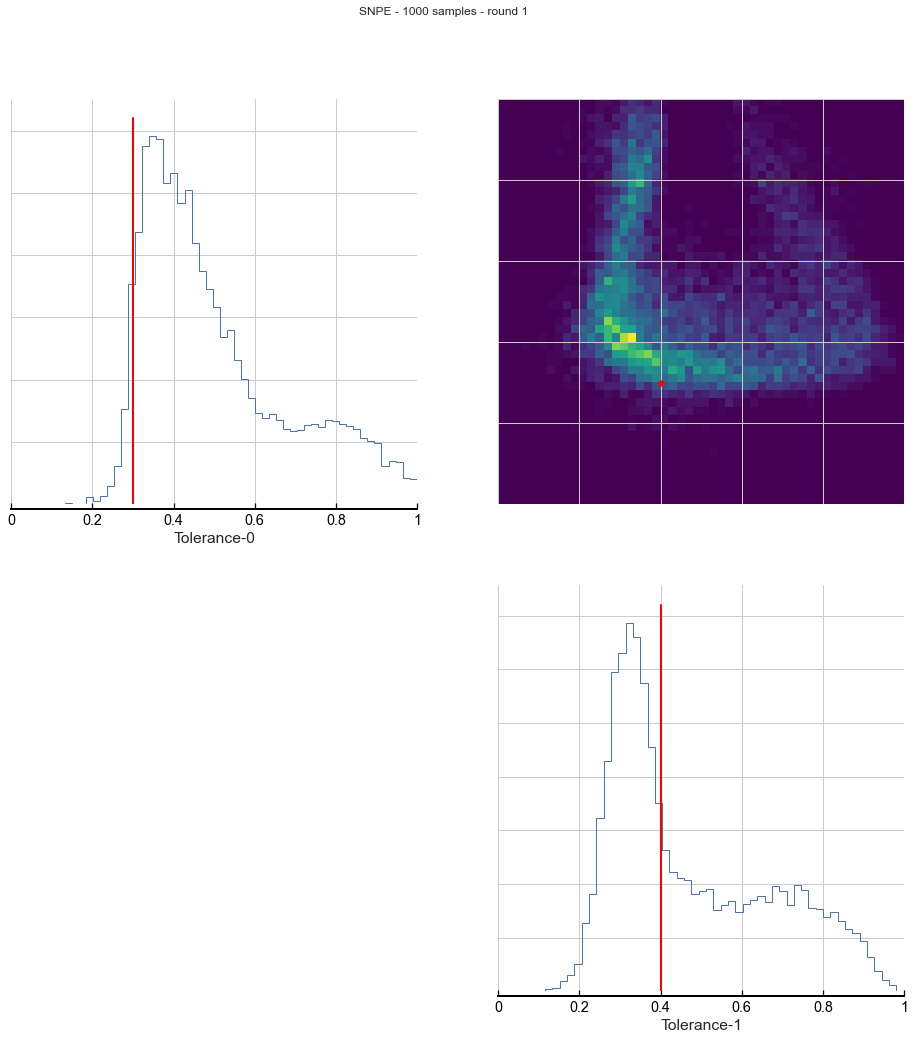

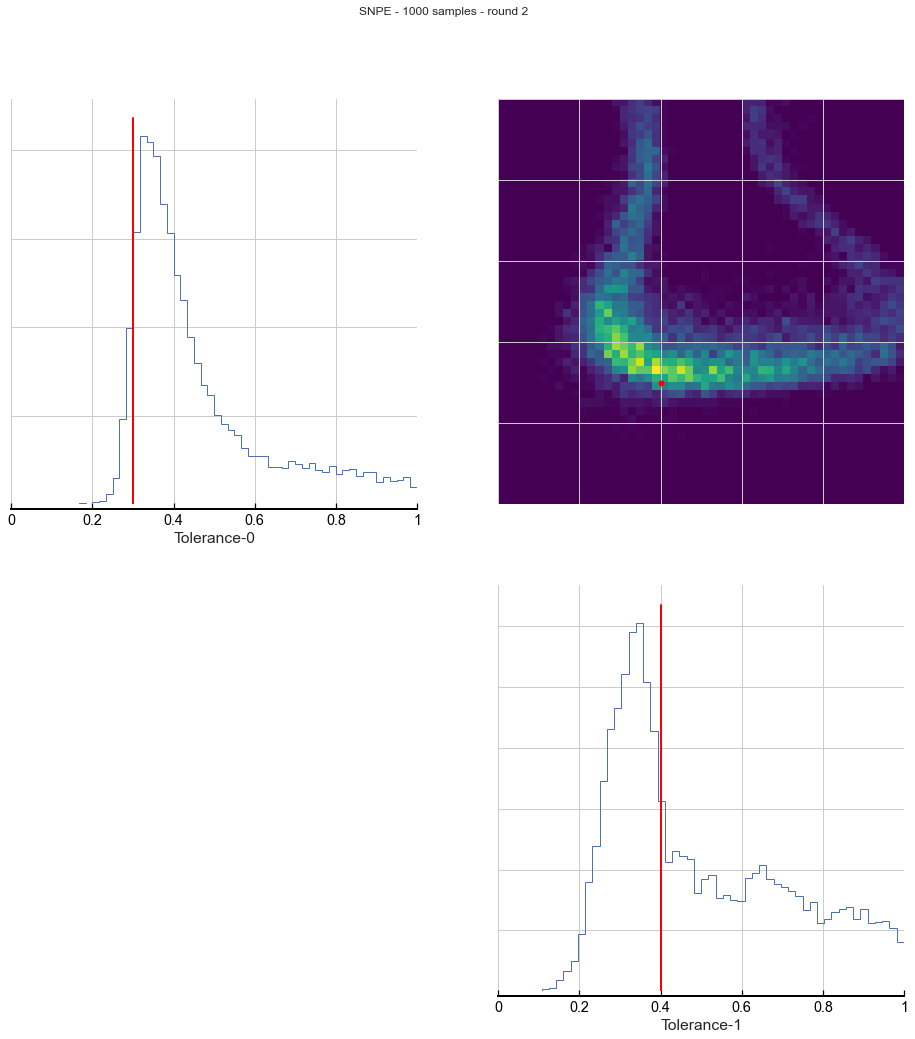

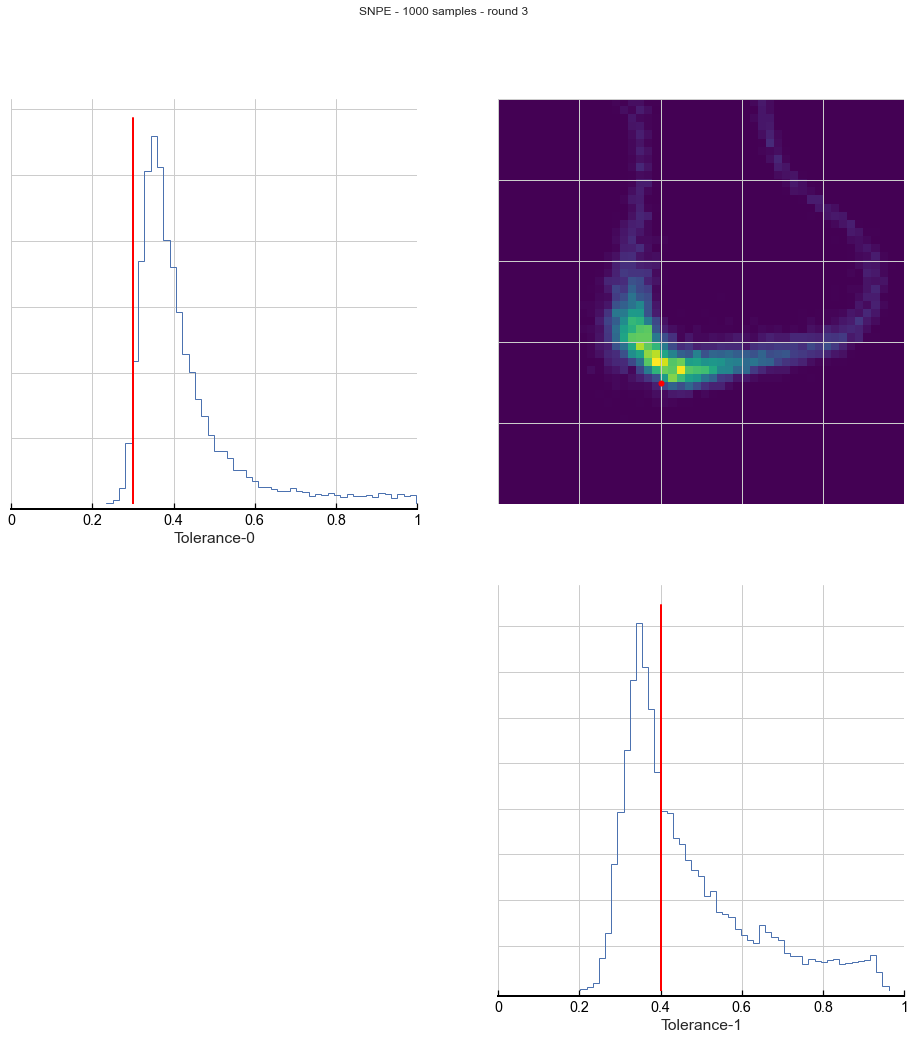

In [5]:
import seaborn as sns
import matplotlib as mpl

sns.set(style="whitegrid", font_scale=1.3)
plt.style.use('paper.mplstyle.txt')
mpl.rc('image', cmap='viridis')

names = ['Tolerance']#, 'Stdev.']

calibration_dict = {'Tolerance':{'names':['Tolerance' + '-' + str(i) for i in range(2)],
                                       'limits':[[0,1],[0,1]],
                                       'true':[true_mu1, true_mu2]
                                        },
#                    'Stdev.':{'names':['Stdev.' + '-' + str(i) for i in range(2)],
#                                        'limits':[[0,1],[0,1]],
#                                        'true':[true_std1, true_std2]
#                                         },
                   }


for i, posterior in enumerate(posteriors):
    
    samples = posterior.sample((10000,), x=observation)
    log_probability = posterior.log_prob(samples, x=observation)
    
    labels, limits, true_values = [], [], []
    for name in names:
        labels += calibration_dict[name]['names']
        limits += calibration_dict[name]['limits']

        
    for j, name in enumerate(names):
        
        true_values = [[0]*j*2 + calibration_dict[name]['true']]

        fig, axes = analysis.pairplot(
            samples,
            subset=[k for k in range(j*2,j*2+2)],
            limits=limits,
            figsize=(16, 16),
            points=true_values,
            points_offdiag={"markersize": 10},
            points_colors=['red']*20,
            labels=labels,
        )
        fig.suptitle('SNPE - ' + str(num_simulations[i]) + ' samples - round ' + str(i+1))